### MATLAB Reader & Feature Map (Lab)
Sets up the extractor and Bottom-Track (BT) preprocessor, declares lab flow-rate `.mat` paths and feature map, and populates `processed_data` with per-flow ensemble-mean matrices and scalar fields (up to 1,620 steps).

In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np

def process_flow_rate(file_path, feature_name, field_name, matrix_field=True, max_time_steps=1620, preprocess=None):
    """
    Load and process a flow rate .mat file to extract data for the specified field in a feature.
    Args:
        file_path (str): Path to the .mat file.
        feature_name (str): Name of the feature to extract (e.g., 'WaterTrack').
        field_name (str): Name of the field within the feature (e.g., 'Vel_StdDev').
        matrix_field (bool): Whether the field is a matrix requiring mean calculation.
        max_time_steps (int): Maximum number of time steps to return.
        preprocess (callable): Optional preprocessing function to apply to the field data.
    Returns:
        np.ndarray: Extracted values for the specified field (processed if matrix_field=True).
    """
    try:
        # Load the MATLAB file
        matlab_data = loadmat(file_path, struct_as_record=False, squeeze_me=True)
        
        # Extract the feature data
        struct_data = matlab_data[feature_name]
        field_data = getattr(struct_data, field_name)  # Dynamically access the field
        
        if preprocess is not None:
            # Apply preprocessing function if provided
            field_data = preprocess(field_data)
        
        if matrix_field:
            # Compute mean values for each time step (if it's a matrix)
            processed_data = np.nanmean(field_data, axis=(0, 1))  # Mean over rows and columns
        else:
            # Directly use the field data if it's scalar
            processed_data = field_data
        
        return processed_data[:max_time_steps]  # Limit to max_time_steps if necessary
    
    except Exception as e:
        print(f"Error processing {file_path} ({field_name}): {e}")
        return None

# Define preprocessing function for Bottom Track Velocity
def preprocess_bottom_track(data):
    # Replace negative values with zero
    data[data < 0] = 0
    # Compute the average of the four columns
    averaged_data = np.nanmean(data, axis=1)  # Average across columns
    return averaged_data

# Define file paths for the selected flow rates
file_paths = {
    
    'Flow Rate 100': r'C:\Users\thtuh\Documents\MATLAB\new lab big data\flow rate 100corrected.mat',
    'Flow Rate 120': r'C:\Users\thtuh\Documents\MATLAB\new lab big data\flow rate 120.mat',
    'Flow Rate 140': r'C:\Users\thtuh\Documents\MATLAB\new lab big data\flow rate 140.mat',
    'Flow Rate 160': r'C:\Users\thtuh\Documents\MATLAB\new lab big data\flow rate 160.mat',
    'Flow Rate 180': r'C:\Users\thtuh\Documents\MATLAB\new lab big data\flow rate 180.mat',
    'Flow Rate 200': r'C:\Users\thtuh\Documents\MATLAB\new lab big data\flow rate 200.mat',
    'Flow Rate 220': r'C:\Users\thtuh\Documents\MATLAB\new lab big data\flow rate 220.mat',
    'Flow Rate 240': r'C:\Users\thtuh\Documents\MATLAB\new lab big data\flow rate 240.mat',
   'Flow Rate 260': r'C:\Users\thtuh\Documents\MATLAB\new lab big data\flow rate 260.mat',
    'Flow Rate 280': r'C:\Users\thtuh\Documents\MATLAB\new lab big data\flow rate 280.mat',
    'Flow Rate 300': r'C:\Users\thtuh\Documents\MATLAB\new lab big data\flow rate 300.mat',
    'Flow Rate 320': r'C:\Users\thtuh\Documents\MATLAB\new lab big data\flow rate 320.mat',
   # 'Flow Rate 340': r'C:\Users\thtuh\Documents\MATLAB\new lab big data\flow rate 340.mat',  #Bottom track value seems 0 , maybe some error
   'Flow Rate 360': r'C:\Users\thtuh\Documents\MATLAB\new lab big data\flow rate 360.mat',
  'Flow Rate 380': r'C:\Users\thtuh\Documents\MATLAB\new lab big data\flow rate 380.mat',
   } 
# Define features and their corresponding fields
features_to_extract = {
    'WaterTrack': {'matrix': ['Vel_StdDev', 'Correlation', 'Vel_Expected_StdDev']},  # Matrix-based features
    'Summary': {'scalar': ['Mean_Speed', 'Depth']},  # Scalar features
    'System': {'matrix': ['SNR'], 'scalar': ['Cell_Size', 'Cell_Start']},
    'BottomTrack': {'scaler': ['BT_Vel']}  # Bottom track velocity (requires preprocessing)
}


# Process each file for all features
processed_data = {}

for label, path in file_paths.items():
    processed_data[label] = {}
    for feature_name, field_groups in features_to_extract.items():
        for field_type, fields in field_groups.items():
            for field_name in fields:
                print(f"Processing {label} - {feature_name} ({field_name})...")
                
                # Apply preprocessing for BottomTrack > BT_Vel
                preprocess = preprocess_bottom_track if feature_name == 'BottomTrack' and field_name == 'BT_Vel' else None
                
                matrix_field = (field_type == 'matrix')  # Determine if it's matrix or scalar
                key = f"{feature_name}_{field_name}"  # Unique key for each feature-field combo
                processed_data[label][key] = process_flow_rate(path, feature_name, field_name, matrix_field, preprocess=preprocess)


for label, features in processed_data.items():
    print(f"Flow Rate: {label}, Features available: {list(features.keys())}")
    break  # Check for first flow rate only


Processing Flow Rate 100 - WaterTrack (Vel_StdDev)...
Processing Flow Rate 100 - WaterTrack (Correlation)...
Processing Flow Rate 100 - WaterTrack (Vel_Expected_StdDev)...
Processing Flow Rate 100 - Summary (Mean_Speed)...
Processing Flow Rate 100 - Summary (Depth)...
Processing Flow Rate 100 - System (SNR)...
Processing Flow Rate 100 - System (Cell_Size)...
Processing Flow Rate 100 - System (Cell_Start)...
Processing Flow Rate 100 - BottomTrack (BT_Vel)...
Processing Flow Rate 120 - WaterTrack (Vel_StdDev)...
Processing Flow Rate 120 - WaterTrack (Correlation)...
Processing Flow Rate 120 - WaterTrack (Vel_Expected_StdDev)...
Processing Flow Rate 120 - Summary (Mean_Speed)...
Processing Flow Rate 120 - Summary (Depth)...
Processing Flow Rate 120 - System (SNR)...
Processing Flow Rate 120 - System (Cell_Size)...
Processing Flow Rate 120 - System (Cell_Start)...
Processing Flow Rate 120 - BottomTrack (BT_Vel)...
Processing Flow Rate 140 - WaterTrack (Vel_StdDev)...
Processing Flow Rate 1

### Build LAB Dataset

Collates per–flow-rate feature arrays into a tidy table (1,620 steps), reorders columns, and exports to Excel.


In [3]:
# Initialize lists for DataFrame content
final_data = []

# Iterate through processed data for all flow rates and features
for label, features in processed_data.items():
    for i in range(1620):  # Assuming each flow rate has up to 1620 time steps
        row = {"Flow Rate": label}  # Add the flow rate label
        for key, values in features.items():
            if values is not None and len(values) > i:
                feature_name = key.split('_', 1)[1]  # Keep the full feature name after the first underscore
                row[feature_name] = values[i]
        final_data.append(row)

# Convert to DataFrame
final_df = pd.DataFrame(final_data)
# List of features to check
features_to_check = ['BT_Vel', 'Depth', 'Vel_StdDev', 'Correlation','Mean_Speed', 'SNR', 'Vel_Expected_StdDev']


# Reorder columns to place 'Flow Rate' first
columns = ["Flow Rate"] + [feature for feature in features_to_check]
final_df = final_df[columns]  # Ensure consistent column order

# Save DataFrame to an Excel file
output_path = r"C:\Users\thtuh\Documents\Onedrive_personal\OneDrive\Personal _Github\ADCP_ML_DL_Journal_1\Processed_Flow_Rate_NEW BIG Data_lab1.xlsx"
final_df.to_excel(output_path, index=False)
print(f"Data saved to {output_path}")

# Verify DataFrame contents
print(final_df.head())


Data saved to C:\Users\thtuh\Documents\Onedrive_personal\OneDrive\Personal _Github\ADCP_ML_DL_Journal_1\Processed_Flow_Rate_NEW BIG Data_lab1.xlsx
       Flow Rate    BT_Vel     Depth  Vel_StdDev  Correlation  Mean_Speed  \
0  Flow Rate 100  0.000008  0.483866    0.000308    46.692308    0.064011   
1  Flow Rate 100  0.000147  0.483523    0.000058    47.019231    0.067394   
2  Flow Rate 100  0.000085  0.483482    0.000038    48.230769    0.069070   
3  Flow Rate 100  0.000065  0.483397    0.000250    46.942308    0.065732   
4  Flow Rate 100  0.000159  0.483460    0.000077    46.769231    0.062065   

         SNR  Vel_Expected_StdDev  
0  44.332727             0.007117  
1  44.194545             0.006781  
2  44.105455             0.006543  
3  44.309091             0.007003  
4  44.285455             0.006860  


### Build Final LAB Dataset with ABS

Stacks per–flow-rate ensembles, derives **Bin_Distance** and **Relative_ABS** (range-corrected backscatter; α = 0.07), orders columns, and exports to Excel.


In [4]:
final_data = []

alpha = 0.07  # Acoustic attenuation (dB/m)

# Iterate through processed data clearly
for label, features in processed_data.items():
    for i in range(1618):
        row = {"Flow Rate": label}

        # Existing features
        for key, values in features.items():
            if values is not None and len(values) > i:
                feature_name = key.split('_', 1)[1]
                row[feature_name] = values[i]

        # Clearly correct feature naming:
        if ('System_Cell_Start' in features) and ('System_Cell_Size' in features) and ('System_SNR' in features):
            bin_distance = features['System_Cell_Start'][i] + (features['System_Cell_Size'][i] / 2)
            row['Bin_Distance'] = bin_distance

            snr_value = features['System_SNR'][i]
            row['Relative_ABS'] = snr_value + 20 * np.log10(bin_distance) + 2 * alpha * bin_distance

        final_data.append(row)

# Convert clearly to DataFrame
final_df = pd.DataFrame(final_data)

# Columns to include explicitly
features_to_check = ['BT_Vel', 'Depth', 'Vel_StdDev', 'Correlation', 
                     'Mean_Speed', 'SNR', 'Vel_Expected_StdDev', 
                     'Bin_Distance', 'Relative_ABS']

# Reorder clearly
columns = ["Flow Rate"] + [feature for feature in features_to_check if feature in final_df.columns]
final_df = final_df[columns]

# Save explicitly to Excel
output_path = r"C:\Users\thtuh\Documents\Onedrive_personal\OneDrive\Personal _Github\ADCP_ML_DL_Journal_1\Processed_Flow_Rate_NEW_BIG_Data_with_ABS.xlsx"
final_df.to_excel(output_path, index=False)

# Quick verification
print(final_df[['Flow Rate', 'Bin_Distance', 'Relative_ABS']].head())
print(f"Data saved successfully to {output_path}")


       Flow Rate  Bin_Distance  Relative_ABS
0  Flow Rate 100      0.106033     24.856393
1  Flow Rate 100      0.106033     24.718205
2  Flow Rate 100      0.106033     24.629110
3  Flow Rate 100      0.106034     24.832807
4  Flow Rate 100      0.106033     24.809132
Data saved successfully to C:\Users\thtuh\Documents\Onedrive_personal\OneDrive\Personal _Github\ADCP_ML_DL_Journal_1\Processed_Flow_Rate_NEW_BIG_Data_with_ABS.xlsx


### Feature Correlation Heatmap

Loads the dataset, defines core features, computes correlations, and draws a heatmap

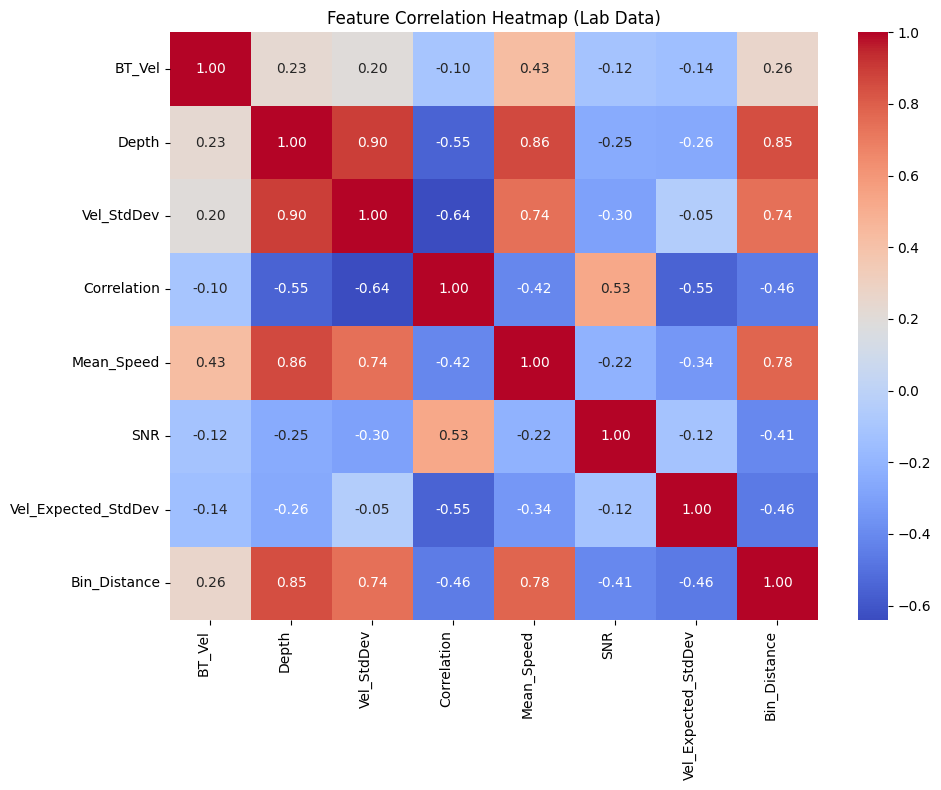

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the processed Excel file
input_path = r'C:\Users\thtuh\Documents\Processed_Flow_Rate_NEW_BIG_Data_with_ABS.xlsx'
final_df = pd.read_excel(input_path)

# List of features to check (Modify this to add/remove features dynamically)
features_to_check = [
    'BT_Vel', 'Depth', 'Vel_StdDev', 'Correlation', 
    'Mean_Speed', 'SNR', 'Vel_Expected_StdDev', 
    'Bin_Distance'
]

# Ensure selected features exist in the DataFrame
available_features = [feature for feature in features_to_check if feature in final_df.columns]

# Exclude the 'Flow Rate' column and select only available features
features_only_df = final_df[available_features]

# Calculate the correlation matrix
correlation_matrix = features_only_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Feature Correlation Heatmap (Lab Data)")
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Distribution by Flow Rate

Renders boxplots for BT_Vel, Depth, SNR, Relative_ABS, etc., grouped by Flow Rate.

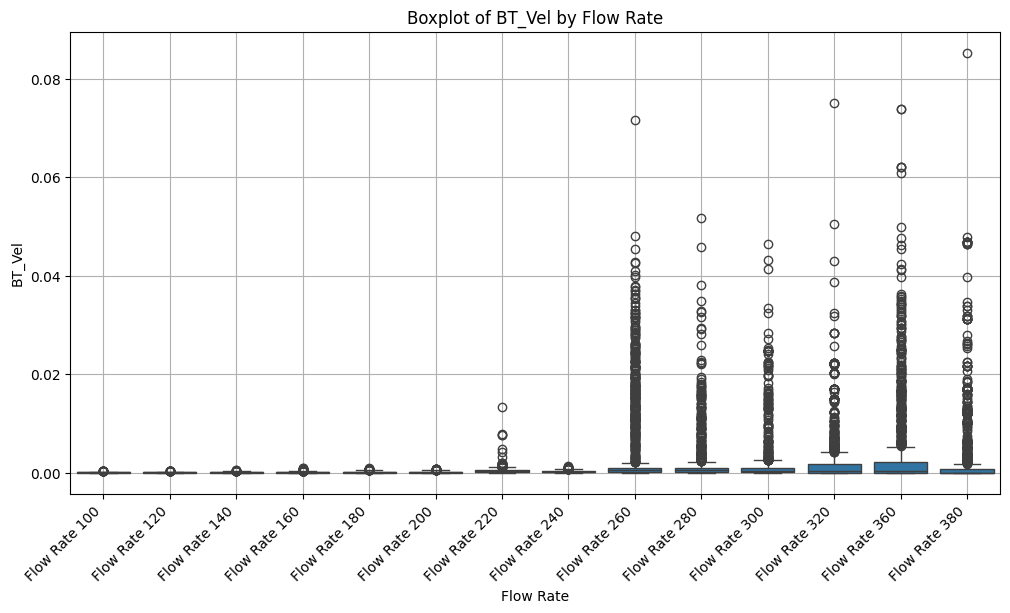

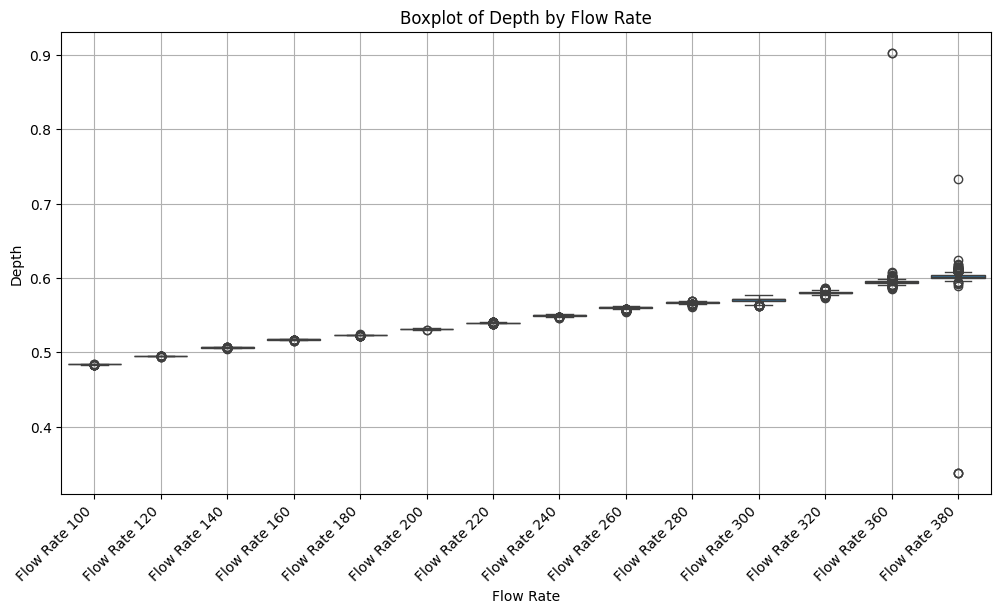

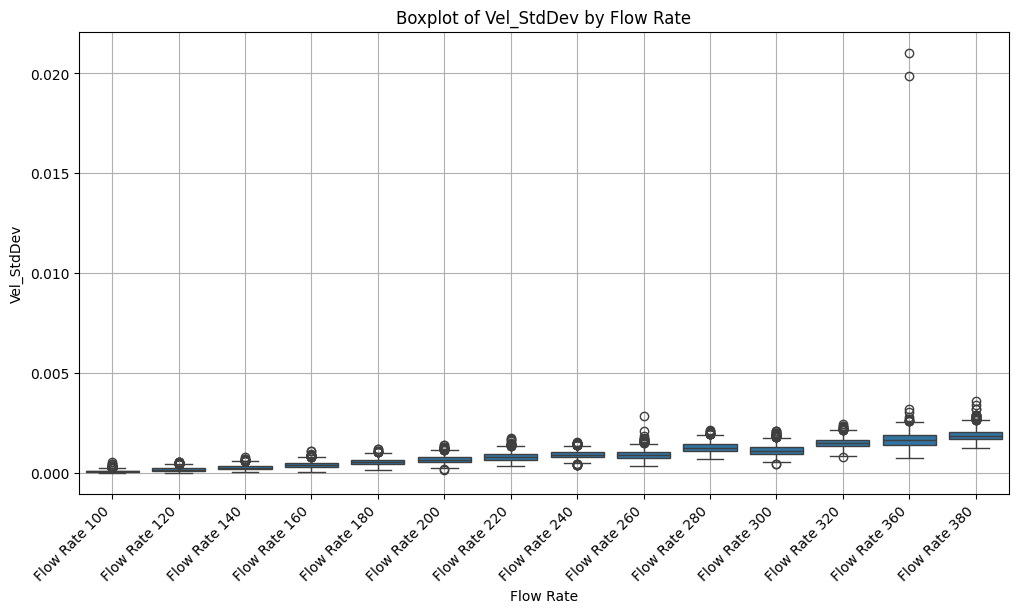

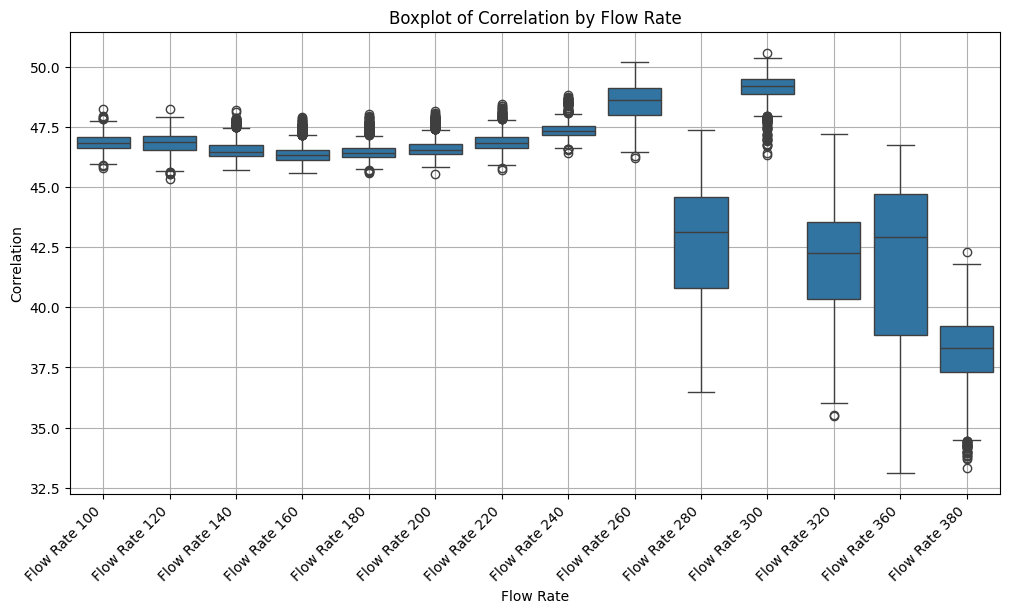

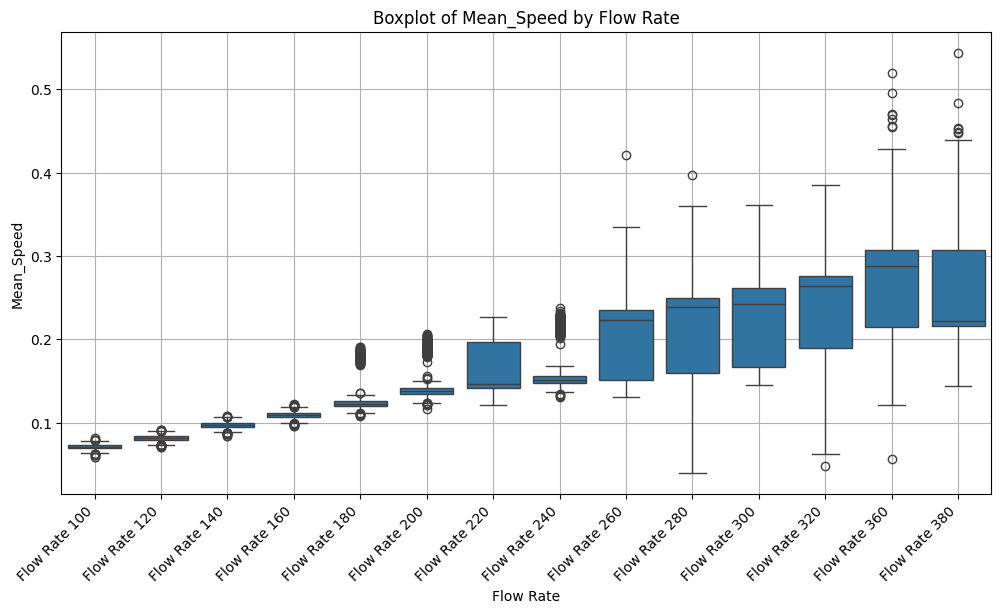

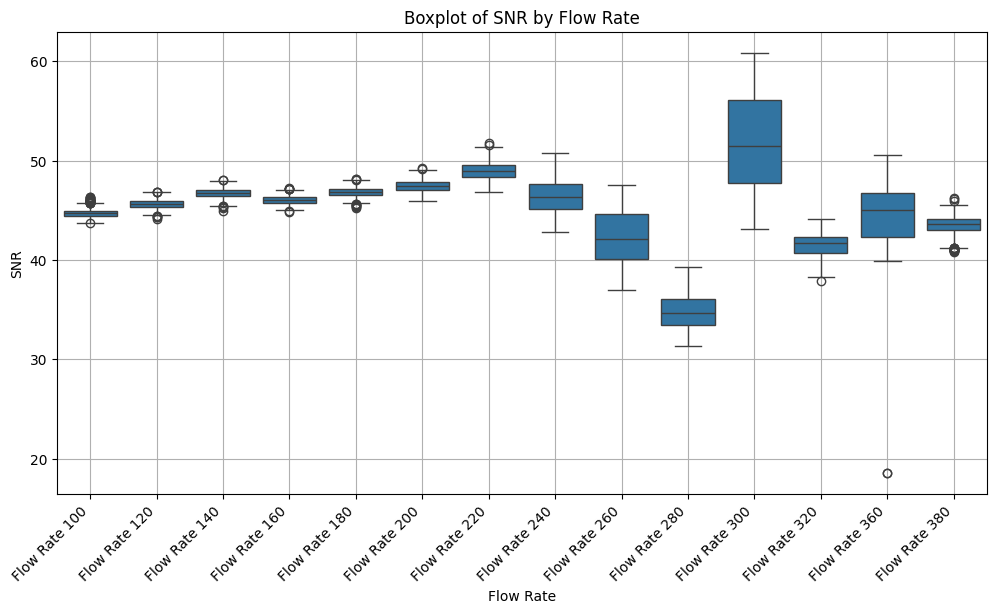

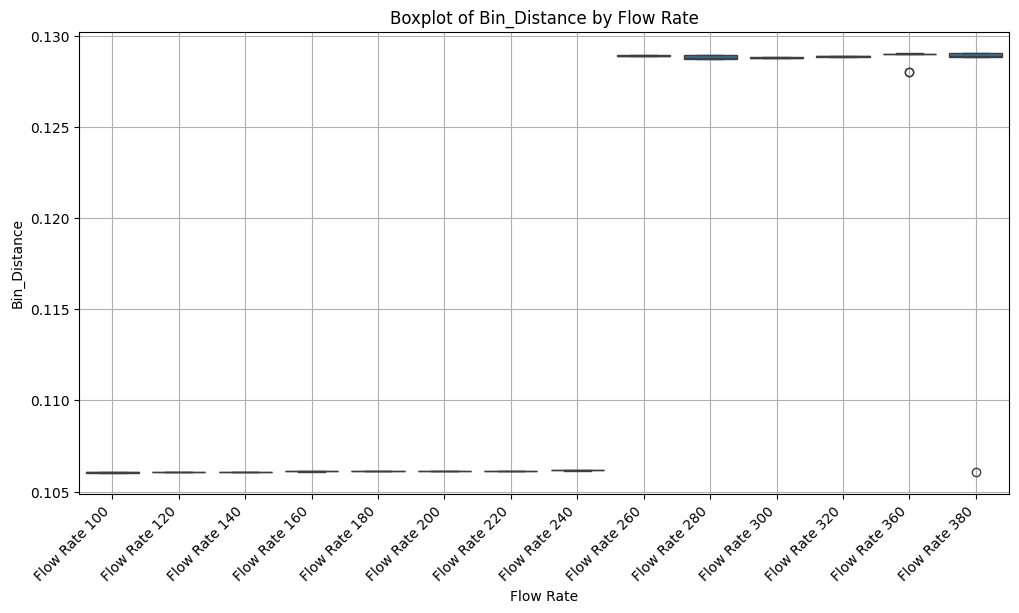

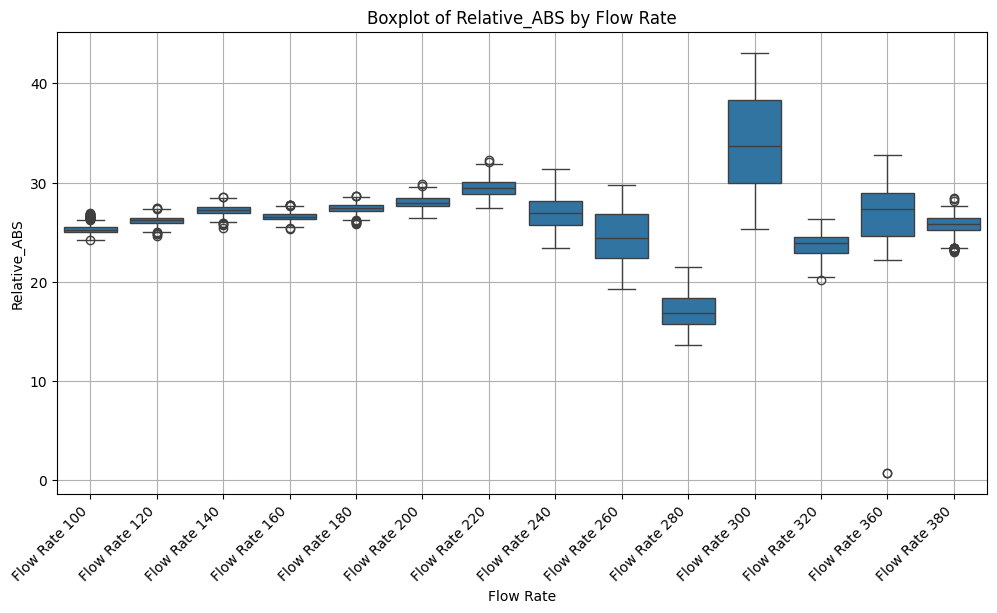

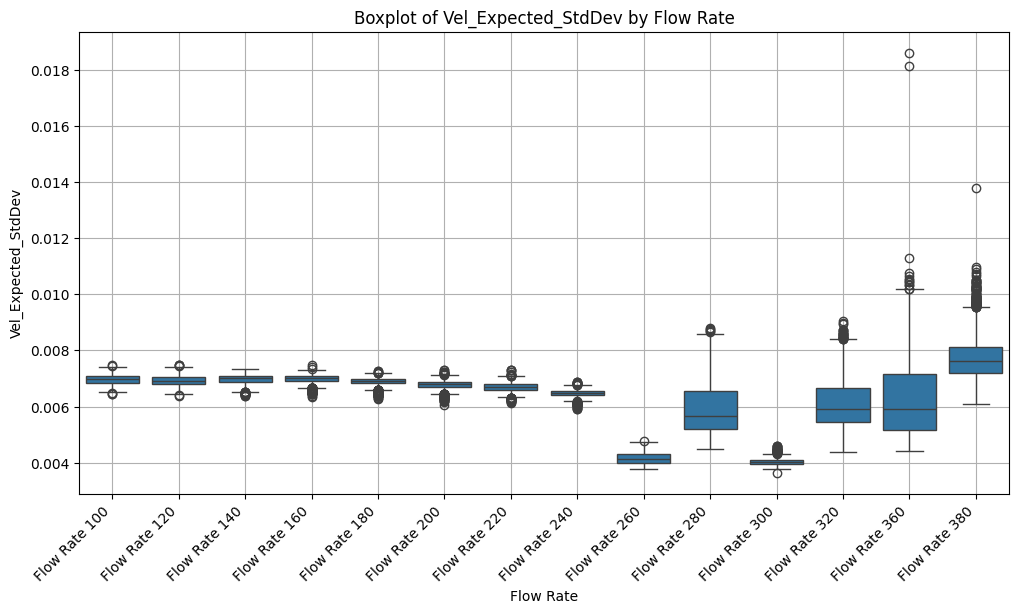

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = r"C:\Users\thtuh\Documents\Processed_Flow_Rate_NEW_BIG_Data_with_ABS.xlsx"  # Update with the correct path
df = pd.read_excel(file_path)

# Check if "Flow Rate" exists in the dataset
if "Flow Rate" in df.columns:
    # Select numeric features for boxplots
    numeric_features = ["BT_Vel", "Depth", "Vel_StdDev", "Correlation", "Mean_Speed", "SNR", "Bin_Distance","Relative_ABS","Vel_Expected_StdDev"]

    # Generate boxplots for each numeric feature grouped by Flow Rate
    for feature in numeric_features:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=df["Flow Rate"], y=df[feature])
        plt.xticks(rotation=45, ha="right")
        plt.title(f"Boxplot of {feature} by Flow Rate")
        plt.xlabel("Flow Rate")
        plt.ylabel(feature)
        plt.grid()
        plt.show()
else:
    print("Error: 'Flow Rate' column not found in the dataset.")